# **Combining Different Models for Ensemble Learning**


We will learn how to do the following:
 - Make predictions based on **majority voting**

 - Use **bagging** to reduce overfitting by drawing random combinations of the training dataset with repetition

 - Apply **boosting** to build powerful models from weak learners that learn from their mistakes


### **Learning with ensembles**

The goal of ensemble methods is to combine different classifiers into a meta-classifier that has better
generalization performance than each individual classifier alone.

**majority voting
principle**: Majority voting simply means that we select the class label that has been predicted by the
majority of classifiers, that is, received more than 50 percent of the votes. Strictly speaking, the term
“majority vote” refers to binary class settings only.


**plurality voting:** generalize the majority voting principle to multiclass settings.

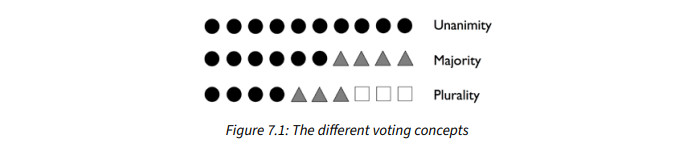

Figure 7.2
illustrates the concept of a general ensemble approach using majority voting:

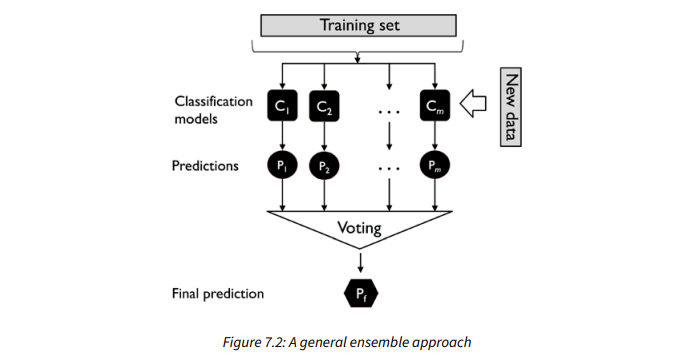




To predict a class label via simple majority or plurality voting, we can combine the predicted class
labels of each individual classifier, Cj, and select the class label,

 <div align="center"> y = mode{C<sub>1</sub>(x),C<sub>2</sub>(x),...,C<sub>m</sub>(x)}

 </div>


(In statistics, the mode is the most frequent event or result in a set. For example, mode{1, 2, 1, 1, 2,
4, 5, 4} = 1.)





In [1]:
from scipy.special import comb
import math


def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [2]:
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

After we have implemented the ensemble_error function, we can compute the ensemble error rates
for a range of different base errors from 0.0 to 1.0 to visualize the relationship between ensemble and
base errors in a line graph:

As you can see in the resulting plot, the error probability of an ensemble
 is always better than the error of an individual base classifier, as long as the
 base classifiers perform better than random guessing (𝜀 < 0.5).
 Note that the y axis depicts the base error (dotted line) as well as the 
 ensemble error (continuous line):



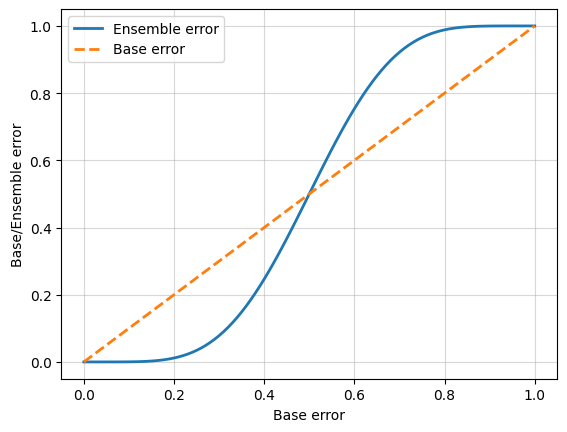

In [3]:
print('As you can see in the resulting plot, the error probability of an ensemble\n \
is always better than the error of an individual base classifier, as long as the\n \
base classifiers perform better than random guessing (𝜀 < 0.5).\n \
Note that the y axis depicts the base error (dotted line) as well as the \n \
ensemble error (continuous line):\n')


import numpy as np


error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]
import matplotlib.pyplot as plt


plt.plot(error_range,
         ens_errors,
         label='Ensemble error',
         linewidth=2)

plt.plot(error_range,
         error_range,
         linestyle='--',
         label='Base error',
         linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
#plt.savefig('figures/07_03.png', dpi=300)
plt.show()

### **Combining classifiers via majority vote**


After the short introduction to ensemble learning in the previous section, let’s start with a warm-up exercise and implement a simple ensemble classifier for majority voting in Python.

**Plurality voting**

Although the majority voting algorithm that we will discuss in this section also generalizes to multiclass settings via plurality voting, the term “majority voting” will be used for
simplicity, as is often the case in the literature.

### **Implementing a simple majority vote classifier**

In [4]:
import numpy as np

np.argmax(np.bincount([0, 0, 1],
                      weights=[0.2, 0.2, 0.6]))

1

In [5]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

p = np.average(ex,
               axis=0,
               weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [6]:
np.argmax(p)

0

Putting everything together, let’s now implement MajorityVoteClassifier in Python:

In [7]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator,
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        y : array-like, shape = [n_examples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' or 'classlabel'"
                             f"; got (vote={self.vote})")

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and weights must be equal'
                             f'; got {len(self.weights)} weights,'
                             f' {len(self.classifiers)} classifiers')

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.

        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out

### **Using the majority voting principle to make predictions**

scikit learn implementation:

In [8]:
# import preprocessing packages
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# load the dataset
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

# train test split
X_train, X_test, y_train, y_test =\
       train_test_split(X, y,
                        test_size=0.5,
                        random_state=1,
                        stratify=y)

In [9]:
# import the classifiers
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score


clf1 = LogisticRegression(penalty='l2',
                          C=0.001,
                          solver='lbfgs',
                          random_state=45)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=45)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

# Note we did not pipeline the Decision tree classifier since they don't need StandardScaler
pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('The output that we receive, as shown in the following snippet,\n\
shows that the predictive performances of the individual classifiers are almost equal:\n')
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} '
          f'(+/- {scores.std():.2f}) [{label}]')

The output that we receive, as shown in the following snippet,
shows that the predictive performances of the individual classifiers are almost equal:

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [10]:
# Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} '
          f'(+/- {scores.std():.2f}) [{label}]')

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


### **Evaluating and tuning the ensemble classifier**

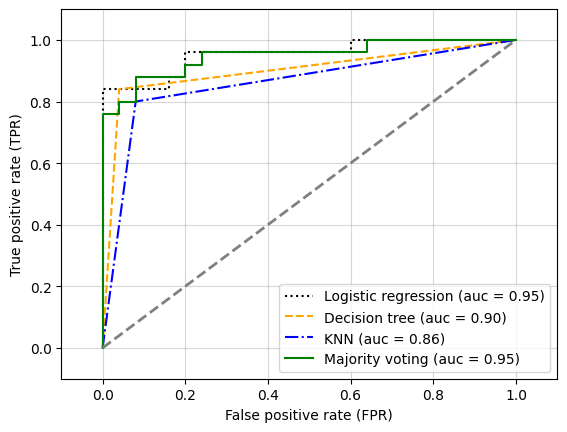

In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label=f'{label} (auc = {roc_auc:.2f})')

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('figures/07_04', dpi=300)
plt.show()

Although it is not necessary to standardize the training features prior to model fitting, because our
logistic regression and k-nearest neighbors pipelines will automatically take care of it, we will standardize the training dataset so that the decision regions of the decision tree will be on the same scale
for visual purposes. The code is as follows:

In [12]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

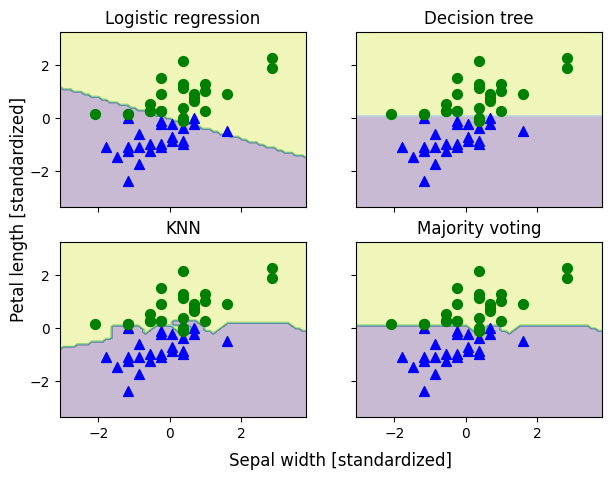

In [13]:
from itertools import product


all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)

    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                  X_train_std[y_train==0, 1],
                                  c='blue',
                                  marker='^',
                                  s=50)

    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                  X_train_std[y_train==1, 1],
                                  c='green',
                                  marker='o',
                                  s=50)

    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5.,
         s='Sepal width [standardized]',
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5,
         s='Petal length [standardized]',
         ha='center', va='center',
         fontsize=12, rotation=90)

#plt.savefig('figures/07_05', dpi=300)
plt.show()

In [14]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=45)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=45),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=45)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=45),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__cl

 Tune the inverse regularization parameter, C, of the logistic regression
classifier and the decision tree depth via a grid search for demonstration purposes:

In [15]:
from sklearn.model_selection import GridSearchCV


params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               random_state=45)]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=45),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            KNeighborsClassifier(n_neighbors=1)]])]),
             param_grid={'decisiontreeclassifier__max_depth': [1, 2],
                         'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
             scoring='roc_auc')

After the grid search has completed, we can print the different hyperparameter value combinations
and the average ROC AUC scores computed via 10-fold cross-validation as follows:

In [16]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    mean_score = grid.cv_results_['mean_test_score'][r]
    std_dev = grid.cv_results_['std_test_score'][r]
    params = grid.cv_results_['params'][r]
    print(f'{mean_score:.3f} +/- {std_dev:.2f} {params}')

0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [17]:
print(f'Best parameters: {grid.best_params_}')

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}


In [18]:
print(f'ROC AUC : {grid.best_score_:.2f}')

ROC AUC : 0.98


**Note:**

As you can see, we get the best cross-validation results when we choose a lower regularization strength
(C=0.001), whereas the tree depth does not seem to affect the performance at all, suggesting that a
decision stump is sufficient to separate the data. To remind ourselves that it is a bad practice to use
the test dataset more than once for model evaluation, we are not going to estimate the generalization
performance of the tuned hyperparameters in this section. We will move on swiftly to an alternative
approach for ensemble learning: bagging.

<br>

**Building ensembles using stacking**

The majority vote approach we implemented in this section is not to be confused with
stacking. The stacking algorithm can be understood as a two-level ensemble, where the
first level consists of individual classifiers that feed their predictions to the second level, where another classifier (typically logistic regression) is fit to the level-one classifier
predictions to make the final predictions.

### **Bagging – building an ensemble of classifiers from bootstrap samples**

We draw bootstrap samples (random samples with replacement)
from the initial training dataset, which is why bagging is also known as bootstrap aggregating.


The concept of bagging is summarized in Figure 7.6:


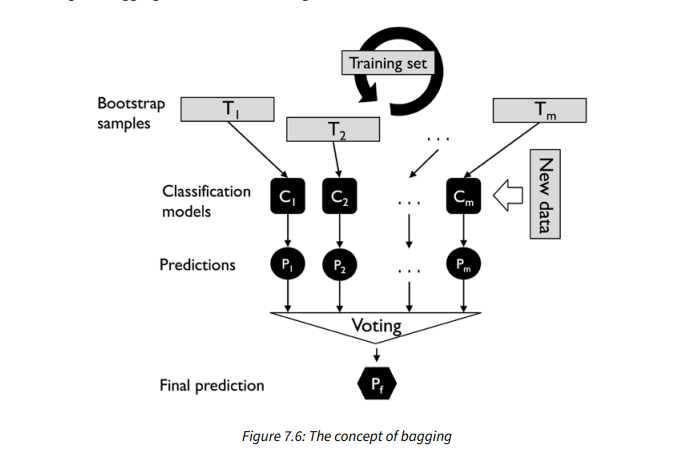

### **Bagging in a nutshell**

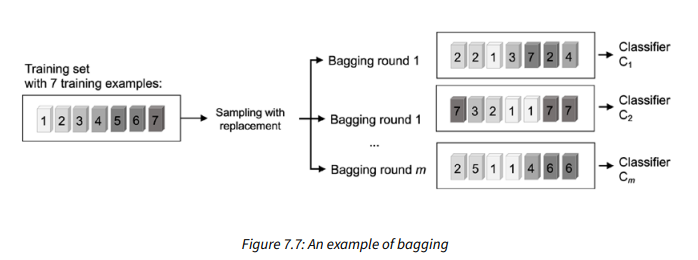

**Note:**  that bagging is also related to the random forest classifier that we introduced in Chapter 3. In
fact, random forests are a special case of bagging where we also use random feature subsets when
fitting the individual decision trees.

### **Applying bagging to classify examples in the Wine dataset**

In [19]:
import pandas as pd


df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

Next, we will encode the class labels into binary format and split the dataset into 80 percent training
and 20 percent test datasets:

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y,
                             test_size=0.2,
                             random_state=1,
                             stratify=y)

A BaggingClassifier algorithm is already implemented in scikit-learn, which we can import from the
ensemble submodule. Here, we will use an unpruned decision tree as the base classifier and create an
ensemble of 500 decision trees fit on different bootstrap samples of the training dataset:


In [21]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=None,
                              random_state=45)

bag = BaggingClassifier(estimator=tree,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=45)

Next, we will calculate the accuracy score of the prediction on the training and test datasets to compare the performance of the bagging classifier to the performance of a

**single unpruned decision tree:**

In [22]:
from sklearn.metrics import accuracy_score

# single decision tree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies '
      f'{tree_train:.3f}/{tree_test:.3f}')



Decision tree train/test accuracies 1.000/0.833


Based on the accuracy values that we printed here, the unpruned decision tree predicts all the class
labels of the training examples correctly; however, the substantially lower test accuracy indicates high
variance (overfitting) of the model:

**Bagging Classifier:**

In [23]:
# Bagging Classifier
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print(f'Bagging train/test accuracies '
      f'{bag_train:.3f}/{bag_test:.3f}')

Bagging train/test accuracies 1.000/0.917


Although the training accuracies of the decision tree and bagging classifier are similar on the training
dataset (both 100 percent), we can see that the bagging classifier has a slightly better generalization
performance, as estimated on the test dataset. Next, let’s compare the decision regions between the
decision tree and the bagging classifier:

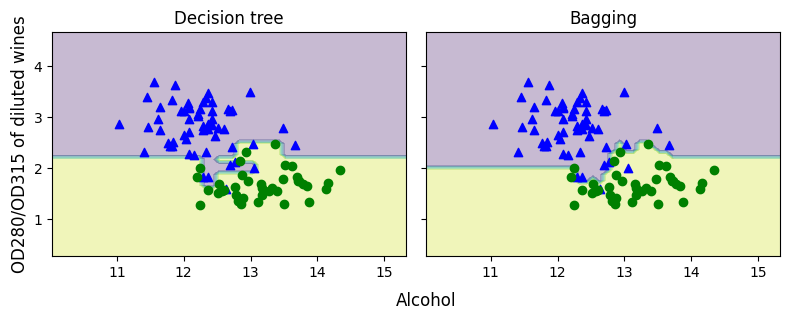

In [24]:
# Note only two features were chosen for visualization purpose
import numpy as np
import matplotlib.pyplot as plt


x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('OD280/OD315 of diluted wines', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='Alcohol',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

#plt.savefig('figures/07_08.png', dpi=300, bbox_inches='tight')
plt.show()

**Key points about Bagging Algorithm:**
- more complex classification tasks and a dataset’s high dimensionality can easily lead to overfitting in single decision trees and this is where the bagging algorithm can really play to its strengths.

- The bagging algorithm can be an effective approach to reducing the variance of a model.

- Bagging is ineffective in reducing model bias, that is, models that are too simple to capture the trends
in the data well

## **Leveraging weak learners via adaptive boosting**

In boosting, the ensemble consists of very simple base classifiers, also often referred to as **weak
learners**, which often only have a slight performance advantage over random guessing—a typical
example of a weak learner is a decision tree stump. The key concept behind boosting is to focus on
training examples that are hard to classify, that is, to let the weak learners subsequently learn from
misclassified training examples to improve the performance of the ensemble.


**How adaptive boosting works**

In contrast to bagging, the initial formulation of the boosting algorithm uses random subsets of training examples drawn from the training dataset without replacement; the original boosting procedure
can be summarized in the following four key steps:
 1. Draw a random subset (sample) of training examples, d<sub>1</sub>, without replacement from the training
dataset, D, to train a weak learner, C<sub>1</sub>.
 2. Draw a second random training subset, d<sub>2</sub>, without replacement from the training dataset and add 50 percent of the examples that were previously misclassified to train a weak learner, C<sub>2</sub>.
 3. Find the training examples, d<sub>3</sub>, in the training dataset, D, which C<sub>1</sub> and C<sub>2</sub> disagree upon, to
train a third weak learner, C<sub>3</sub>.
 4. Combine the weak learners C<sub>1</sub>, C<sub>2</sub>, and C<sub>3</sub> via majority voting.

 **Notes about Boosting:**
 - boosting can lead to a decrease
in bias as well as variance compared to bagging models

- boosting algorithms such
as AdaBoost are also known for their high variance, that is, the tendency to overfit the training data



**AdaBoost:**

Uses the complete training
dataset to train the weak learners, where the training examples are reweighted in each iteration to
build a strong classifier that learns from the mistakes of the previous weak learners in the ensemble.

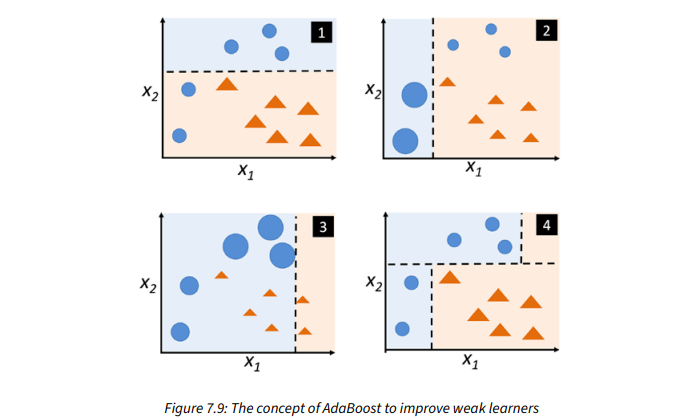

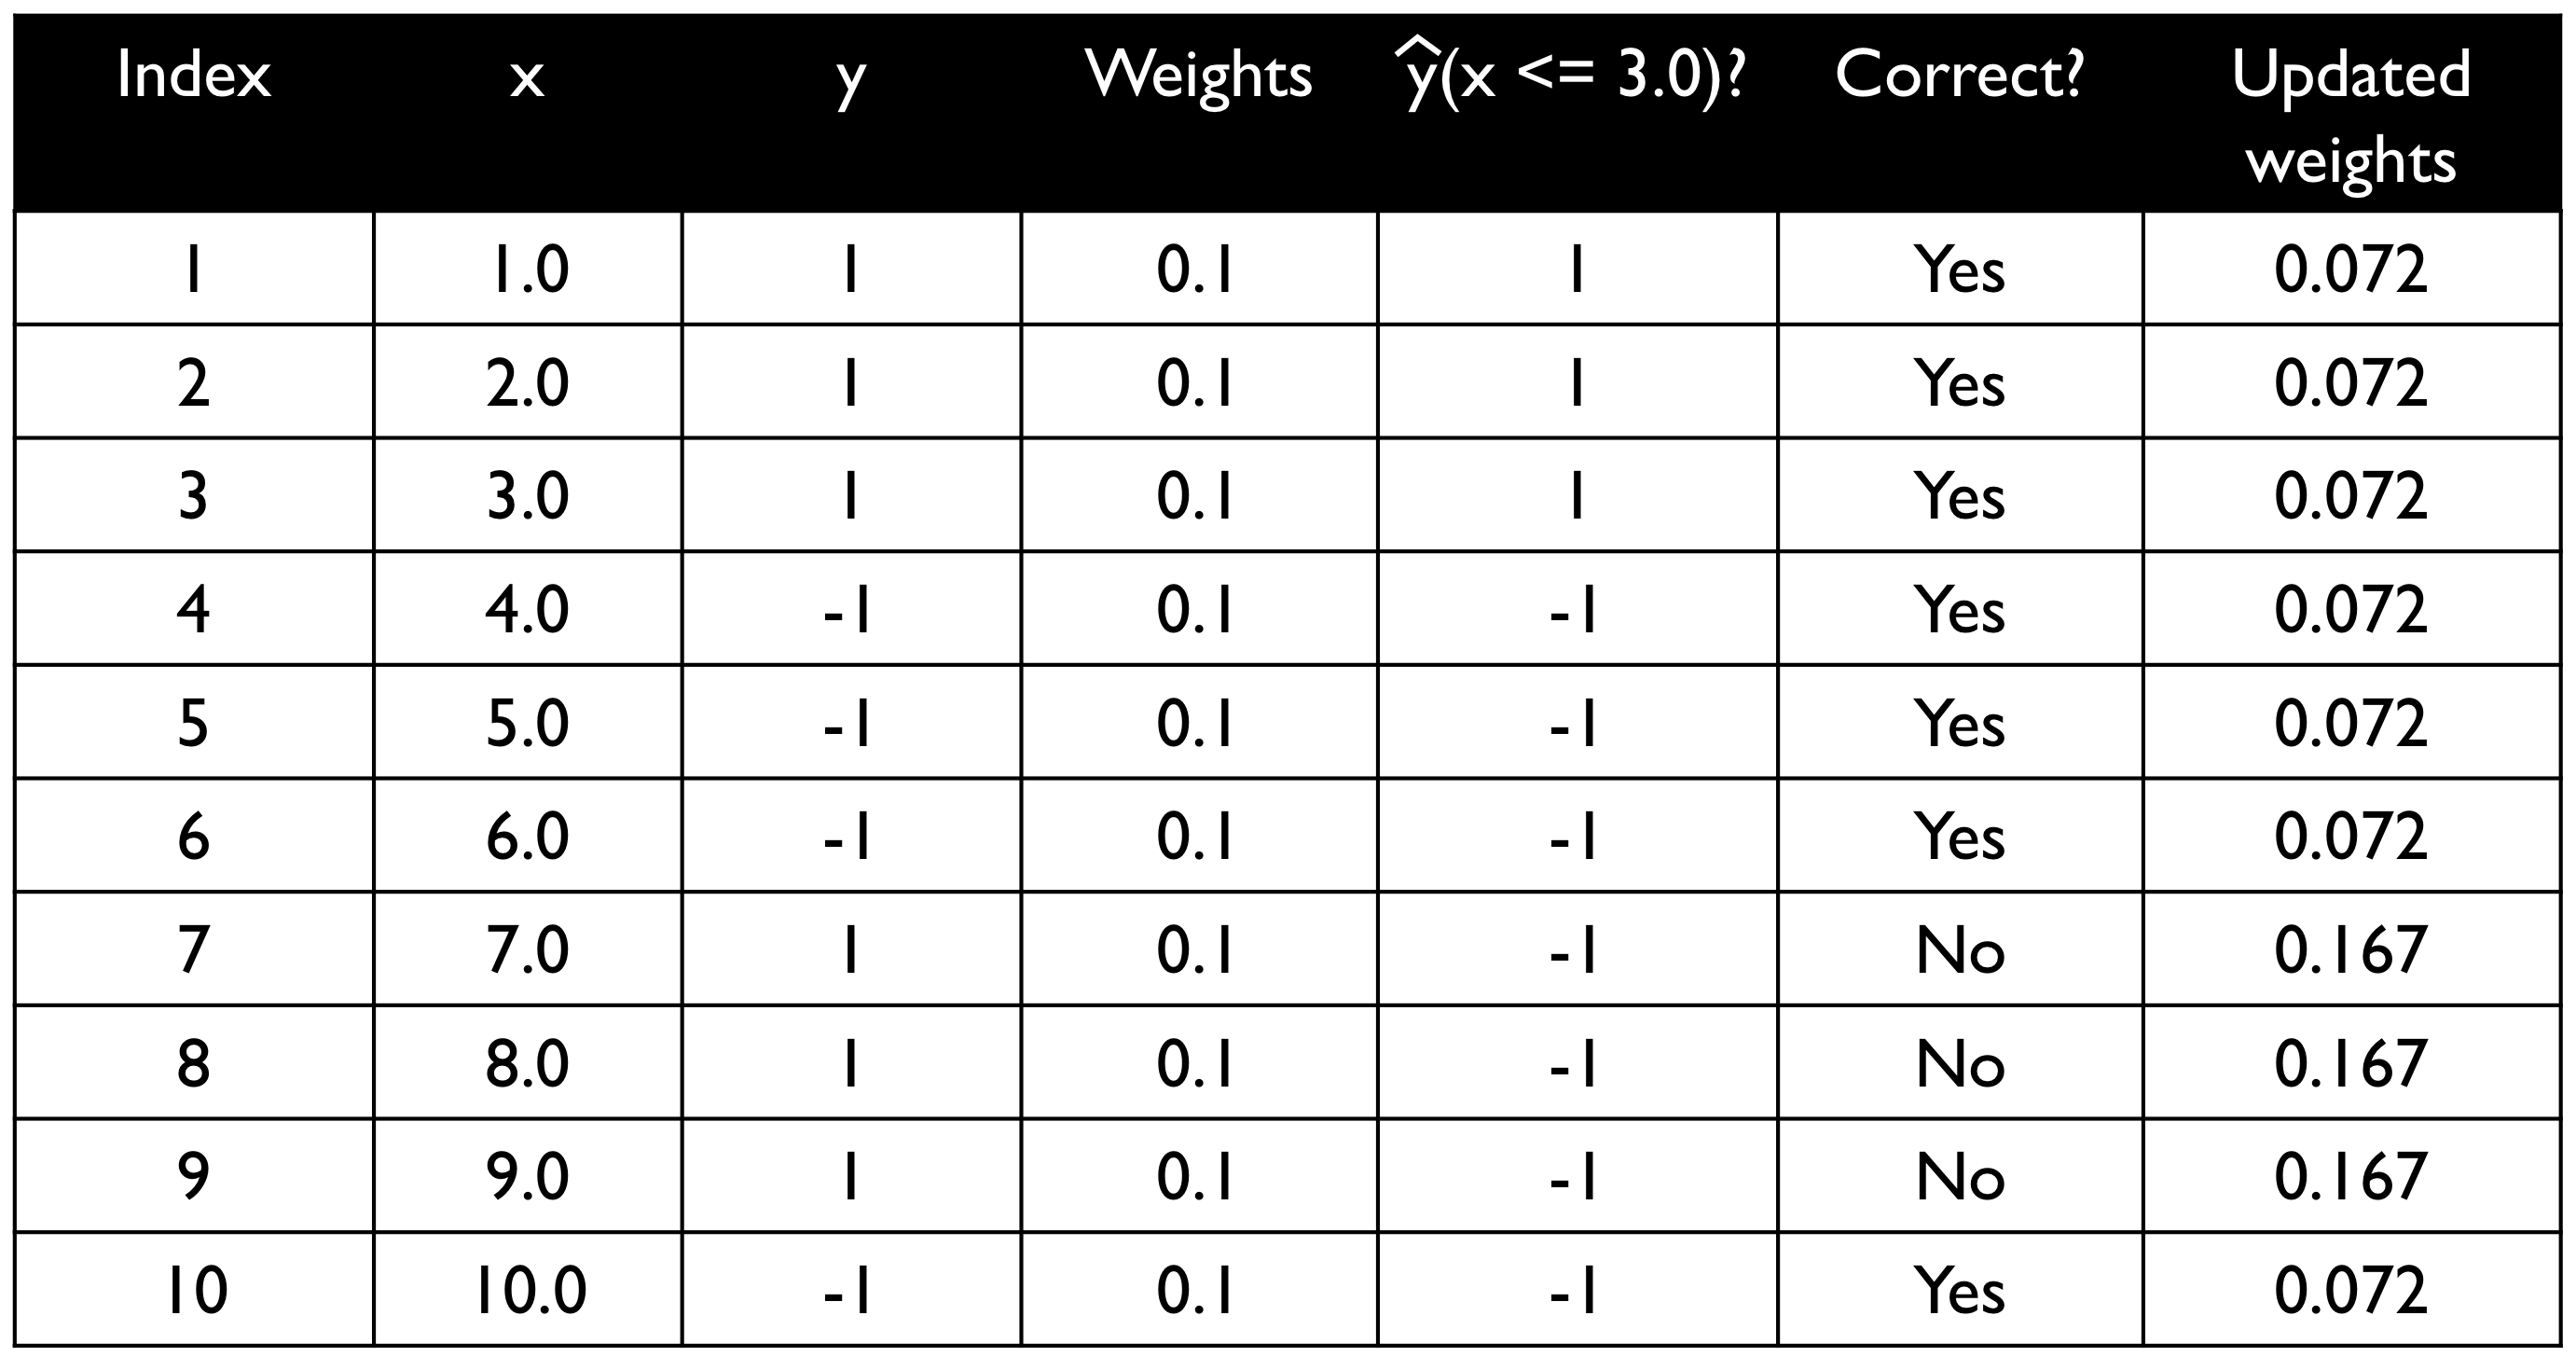

In [25]:
y = np.array([1, 1, 1, -1, -1, -1,  1,  1,  1, -1])
yhat = np.array([1, 1, 1, -1, -1, -1, -1, -1, -1, -1])
correct = (y == yhat)
weights = np.full(10, 0.1)
print(weights)

epsilon = np.mean(~correct)
print(epsilon)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.3


In [32]:
alpha_j = 0.5 * np.log((1-epsilon) / epsilon)
print(alpha_j)

0.42364893019360184


In [33]:
update_if_correct = 0.1 * np.exp(-alpha_j * 1 * 1)
print(update_if_correct)

0.06546536707079771


In [34]:
update_if_wrong_1 = 0.1 * np.exp(-alpha_j * 1 * -1)
print(update_if_wrong_1)

0.1527525231651947


In [35]:
update_if_wrong_2 = 0.1 * np.exp(-alpha_j * -1 * 1)
print(update_if_wrong_2)

0.1527525231651947


In [36]:
weights = np.where(correct == 1, update_if_correct, update_if_wrong_1)
print(weights)

[0.06546537 0.06546537 0.06546537 0.06546537 0.06546537 0.06546537
 0.15275252 0.15275252 0.15275252 0.06546537]


In [37]:
normalized_weights = weights / np.sum(weights)
print(normalized_weights)

[0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.16666667 0.16666667 0.16666667 0.07142857]


### **Applying AdaBoost using scikit-learn**

Via the base_estimator attribute, we will train the AdaBoostClassifier on 500 decision tree stumps:

In [40]:
from sklearn.ensemble import AdaBoostClassifier

# single decision tree
tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=1,
                              random_state=1)

# adaboost with 500 decision trees
ada = AdaBoostClassifier(estimator=tree,
                         n_estimators=500,
                         learning_rate=0.1,
                         random_state=45)

In [42]:
# fitting and predicting on both train/test datA
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

# Decision tree accuracy on the train/test
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies '
      f'{tree_train:.3f}/{tree_test:.3f}')

# fitting/predictng Adaboost
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

# adaboost accuracy on the train/test
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print(f'AdaBoost train/test accuracies '
      f'{ada_train:.3f}/{ada_test:.3f}')

Decision tree train/test accuracies 0.916/0.875
AdaBoost train/test accuracies 1.000/0.917


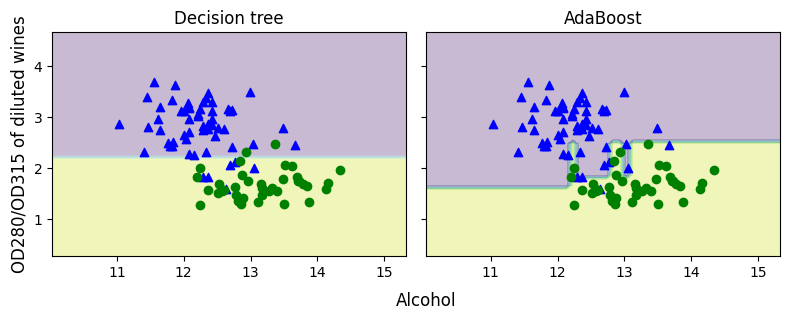

In [43]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('OD280/OD315 of diluted wines', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='Alcohol',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

# plt.savefig('figures/07_11.png', dpi=300, bbox_inches='tight')
plt.show()

### **Gradient boosting – training an ensemble based on loss gradients**

### **Comparing AdaBoost with gradient boosting**

 - AdaBoost trains decision tree stumps based on errors of the previous decision tree stump. In
particular, the errors are used to compute sample weights in each round as well as for computing a classifier weight for each decision tree stump when combining the individual stumps into an ensemble. We stop training once a maximum number of iterations (decision tree stumps) is reached.
 - Like AdaBoost, gradient boosting fits decision trees in an iterative fashion using prediction errors.
 - However, gradient boosting trees are usually deeper than decision tree stumps and have typically a maximum depth of 3 to 6 (or a maximum number of 8 to 64 leaf nodes).
 - Also, in contrast to AdaBoost, gradient boosting does not use the prediction errors for assigning sample weights; they are used directly to form the target variable for fitting the next tree.
 - Moreover, instead of having an individual weighting term for each tree, like in AdaBoost, gradient boosting uses a global learning rate that is the same for each tree.


 ### **Outlining the general gradient boosting algorithm**




## **Using XGBoost**

It is important to note that gradient boosting is a sequential process that can be slow to train. However, in recent years a more popular implementation of gradient boosting has emerged, namely, XGBoost.

XGBoost proposed several tricks and approximations that speed up the training process substantially.
Hence, the name XGBoost, which stands for extreme gradient boosting. Moreover, these approximations and tricks result in very good predictive performances.



- XGBoost: https://xgboost.readthedocs.io/en/stable/
-  LightGBM: https://lightgbm.readthedocs.io/en/latest/
- CatBoost: https://catboost.ai
- HistGradientBoostingClassifier: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html

In [44]:
import xgboost as xgb
xgb.__version__

'2.0.0'

In [50]:
model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=4, random_state=1, use_label_encoder=False)


gbm = model.fit(X_train, y_train)

y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)

gbm_train = accuracy_score(y_train, y_train_pred)
gbm_test = accuracy_score(y_test, y_test_pred)
print(f'XGboost train/test accuracies '
      f'{gbm_train:.4f}/{gbm_test:.4f}')

XGboost train/test accuracies 0.9684/0.9167
